In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
market_data_1 = pd.read_csv("../data/market_data1.csv")
market_data_2 = pd.read_csv("../data/market_data2.csv")
market_data_3 = pd.read_csv("../data/market_data3.csv")
market_data_4 = pd.read_csv("../data/market_data4.csv")

In [ ]:
FUT = 0
ETF = 1

In [ ]:
market_data_1[market_data_1["Instrument"] == ETF].tail()

In [ ]:
etf_trades = market_data_1[market_data_1["Instrument"] == ETF]
fut_trades = market_data_1[market_data_1["Instrument"] == FUT]

In [ ]:
market_data_1["MidPriceETF"] = market_data_1["Price"]
market_data_1["MidPriceFUT"] = market_data_1["Price"]

In [ ]:
market_data_1["LastTradedPriceETF"] = market_data_1["Price"]
market_data_1["LastTradedPriceFUT"] = market_data_1["Price"]

In [ ]:
etf_trades.head()

In [ ]:
etf_fut_midprices = market_data_1[market_data_1.columns[~market_data_1.columns.isin(['col3', 'col4'])]]

## Darts

In [2]:
from darts import TimeSeries

In [3]:
from darts.datasets import ETTh2Dataset

In [4]:
series = ETTh2Dataset().load()[:10000][["MUFL", "LULL"]]

In [5]:
series.head()

<TimeSeries (DataArray) (date: 5, component: 2, sample: 1)>
array([[[36.5359993 ],
        [ 1.31099999]],

       [[33.93600082],
        [ 1.21500003]],

       [[35.33000183],
        [ 0.        ]],

       [[35.54399872],
        [ 1.21500003]],

       [[35.40999985],
        [ 0.        ]]])
Coordinates:
  * date       (date) datetime64[ns] 2016-07-01 ... 2016-07-01T04:00:00
  * component  (component) object 'MUFL' 'LULL'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [6]:
train, val = series.split_before(0.6)

In [7]:
from darts.ad import KMeansScorer

scorer = KMeansScorer(k=2, window=5)

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
scorer.fit(train)
anom_score = scorer.score(val)

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
from darts.ad import QuantileDetector

In [10]:
detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anom = detector.detect(anom_score)

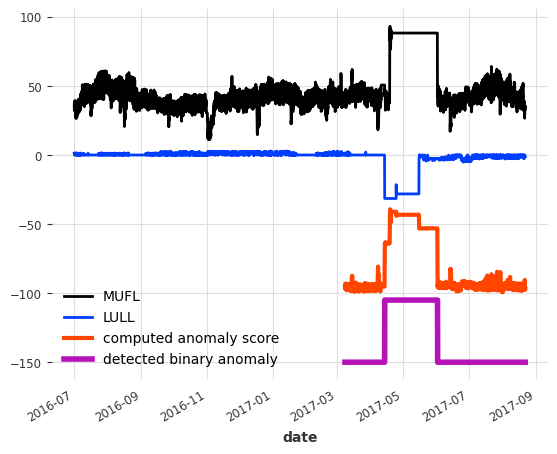

In [11]:
series.plot()
(anom_score / 2. - 100).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * 45 - 150).plot(label="detected binary anomaly", lw=4)

In [12]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

In [13]:
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [14]:
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)

In [15]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

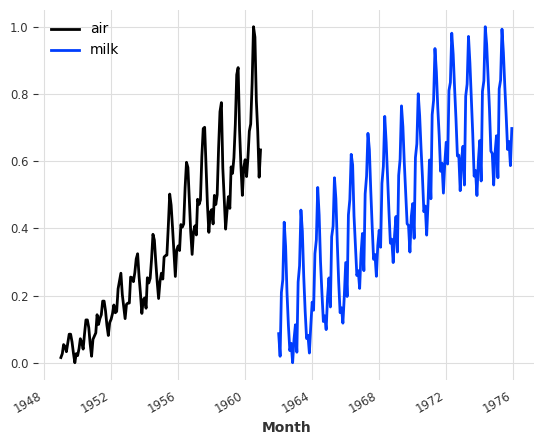

In [16]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend();

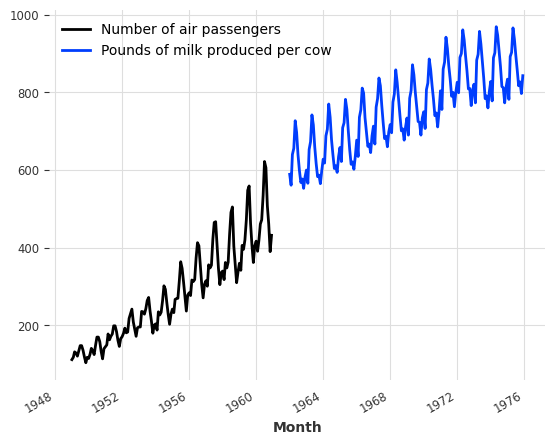

In [17]:
series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend();

In [18]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

Important parameters:

`input_chunk_length` the length of the lookback window

`output_chunk_length` the length of the outputs produced by the forecast model

In [19]:
model_air = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=200, random_state=0
)

In [20]:
!export PYTORCH_ENABLE_MPS_FALLBACK=1

In [21]:
model_air.fit(train_air, verbose=True)

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.